In [40]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [72]:
img, label = mnist[0]
print('Label: ', label)
# print(img[:])
torch.min(img), torch.max(img) # minimum and maximum of the tensor

Label:  5


(tensor(-1.), tensor(1.))

In [73]:
def denorm(x):
    
    return ((x*0.5)/0.5)

Label: 5


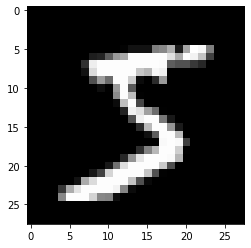

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [62]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [63]:
image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [64]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [65]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())


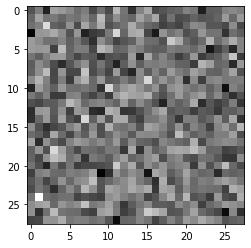

In [66]:
plt.imshow(gen_imgs[0], cmap='gray')

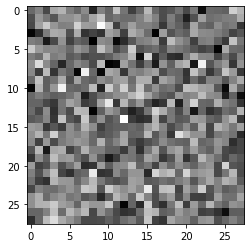

In [67]:
plt.imshow(gen_imgs[1], cmap='gray')

In [68]:
a = torch.randn(4)
print(a)
print(a.clamp(0,1))

tensor([-0.4043,  0.5225,  0.1532, -0.8077])
tensor([0.0000, 0.5225, 0.1532, 0.0000])


In [75]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [76]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [78]:
%%time



num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        

Epoch [0/50], Step [200/600], d_loss: 0.0545, g_loss: 5.0622, D(x): 0.98, D(G(z)): 0.04
Epoch [0/50], Step [400/600], d_loss: 0.1609, g_loss: 3.1419, D(x): 0.98, D(G(z)): 0.13
Epoch [0/50], Step [600/600], d_loss: 0.3804, g_loss: 4.6112, D(x): 0.91, D(G(z)): 0.14
Epoch [1/50], Step [200/600], d_loss: 0.2151, g_loss: 4.7346, D(x): 0.91, D(G(z)): 0.08
Epoch [1/50], Step [400/600], d_loss: 0.4847, g_loss: 3.0729, D(x): 0.80, D(G(z)): 0.15
Epoch [1/50], Step [600/600], d_loss: 1.4891, g_loss: 2.5891, D(x): 0.81, D(G(z)): 0.58
Epoch [2/50], Step [200/600], d_loss: 0.7911, g_loss: 2.1106, D(x): 0.70, D(G(z)): 0.10
Epoch [2/50], Step [400/600], d_loss: 0.5540, g_loss: 2.0820, D(x): 0.88, D(G(z)): 0.29
Epoch [2/50], Step [600/600], d_loss: 0.9225, g_loss: 2.3034, D(x): 0.73, D(G(z)): 0.26
Epoch [3/50], Step [200/600], d_loss: 0.1478, g_loss: 3.5929, D(x): 0.97, D(G(z)): 0.11
Epoch [3/50], Step [400/600], d_loss: 0.3282, g_loss: 3.7857, D(x): 0.90, D(G(z)): 0.13
Epoch [3/50], Step [600/600], d_

Epoch [31/50], Step [200/600], d_loss: 0.3868, g_loss: 2.8075, D(x): 0.84, D(G(z)): 0.10
Epoch [31/50], Step [400/600], d_loss: 0.6306, g_loss: 2.7660, D(x): 0.84, D(G(z)): 0.23
Epoch [31/50], Step [600/600], d_loss: 0.4479, g_loss: 3.3867, D(x): 0.86, D(G(z)): 0.14
Epoch [32/50], Step [200/600], d_loss: 0.4081, g_loss: 2.8528, D(x): 0.93, D(G(z)): 0.21
Epoch [32/50], Step [400/600], d_loss: 0.4768, g_loss: 3.0749, D(x): 0.88, D(G(z)): 0.16
Epoch [32/50], Step [600/600], d_loss: 0.3586, g_loss: 3.5742, D(x): 0.89, D(G(z)): 0.12
Epoch [33/50], Step [200/600], d_loss: 0.3284, g_loss: 4.2464, D(x): 0.88, D(G(z)): 0.08
Epoch [33/50], Step [400/600], d_loss: 0.4337, g_loss: 3.3648, D(x): 0.87, D(G(z)): 0.12
Epoch [33/50], Step [600/600], d_loss: 0.4300, g_loss: 5.0619, D(x): 0.84, D(G(z)): 0.03
Epoch [34/50], Step [200/600], d_loss: 0.3279, g_loss: 3.7646, D(x): 0.93, D(G(z)): 0.11
Epoch [34/50], Step [400/600], d_loss: 0.3979, g_loss: 3.4267, D(x): 0.97, D(G(z)): 0.22
Epoch [34/50], Step [